In [61]:
pip install mglearn

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.0.1 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
%matplotlib inline
from IPython.display import display
import matplotlib_inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import mglearn
from cycler import cycler
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import *
import os

# Libreria per importare CSV da Drive
# from google.colab import drive

matplotlib_inline.backend_inline.set_matplotlib_formats('pdf', 'png')
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['image.cmap'] = "viridis"
plt.rcParams['image.interpolation'] = "none"
plt.rcParams['savefig.bbox'] = "tight"
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['legend.numpoints'] = 1
plt.rc('axes', prop_cycle=(
    cycler('color', mglearn.plot_helpers.cm_cycle.colors) +
    cycler('linestyle', ['-', '-', "--", (0, (3, 3)), (0, (1.5, 1.5))])))

np.set_printoptions(precision=3, suppress=True)

pd.set_option("display.max_columns", None)
pd.set_option('display.precision', 2)

__all__ = ['np', 'mglearn', 'display', 'plt', 'pd']


In [3]:
from sklearn.preprocessing import OneHotEncoder

def ohe(df, list_of_columns):
    # Inizializzare OneHotEncoder
    encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
    
    # Manteniamo una copia del DataFrame originale
    df_encoded = df.copy()

    # Iterare sulle colonne da codificare
    for col in list_of_columns:
        # Applicare OneHotEncoder alla colonna specifica
        encoded = encoder.fit_transform(df[[col]])

        # Creare un DataFrame con le nuove colonne codificate, usando gli stessi indici del DataFrame originale
        encoded_df = pd.DataFrame(encoded, columns=encoder.get_feature_names_out([col]), index=df.index)

        # Concatenare le nuove colonne codificate al DataFrame originale
        df_encoded = pd.concat([df_encoded, encoded_df], axis=1)
    df_encoded = df_encoded.drop(list_of_columns, axis=1)

    # Restituire il DataFrame finale, mantenendo le colonne originali
    return df_encoded

In [4]:
def train(df, model):
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    print(f'Accuratezza: {accuracy}')

    # Calcolare la precisione
    precision = precision_score(y_test, y_pred)
    print(f'Precisione: {precision}')

    # Calcolare il recall (sensibilità)
    recall = recall_score(y_test, y_pred)
    print(f'Recall: {recall}')

    # Calcolare FPR (False Positive Ration)
    print(f'FPR: {1 - recall}')

    # Matrice di confusione
    cm = confusion_matrix(y_test, y_pred)
    print(f'Matrice di confusione:\n{cm}')
    return model

In [5]:
def test(df, model):
    
    df = ohe(df,['employment_status','payment_type','housing_status', 'source', 'device_os'])
    y_pred = model.predict(df.drop(['fraud_bool'], axis=1))
    y_test = df['fraud_bool']

    accuracy = accuracy_score(y_test, y_pred)
    print(f'Accuratezza: {accuracy}')

    # Calcolare la precisione
    precision = precision_score(y_test, y_pred)
    print(f'Precisione: {precision}')

    # Calcolare il recall (sensibilità)
    recall = recall_score(y_test, y_pred)
    print(f'Recall: {recall}')

    # Calcolare FPR (False Positive Ration)
    print(f'FPR: {1 - recall}')

    # Matrice di confusione
    cm = confusion_matrix(y_test, y_pred)
    print(f'Matrice di confusione:\n{cm}')

    print('\n__________\n')

In [29]:

#Recall = TN / (TN + FP)
#FPR = FP / = 1 - Recall

0.849744711889132

# (75-25 con rapporto 1 a 50)

In [6]:
df = pd.read_csv("Base.csv").drop(['device_fraud_count', 'month'], axis=1)

In [7]:
df_frodi = df[(df['fraud_bool'] == 1)]
n = df[(df['fraud_bool'] == 1)].shape[0]
print(n)
df_not_frodi = df[(df['fraud_bool'] != 1)].head(n*50)

df = pd.concat([df_frodi, df_not_frodi])

from sklearn.model_selection import train_test_split
df = ohe(df,['employment_status','payment_type','housing_status', 'source', 'device_os'])
X_train, X_test, y_train, y_test = train_test_split(df.drop(['fraud_bool'], axis=1), df['fraud_bool'], random_state=0)

11029


## Train RandomForestClassifier

In [8]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier()

model = train(df, model)

Accuratezza: 0.9829967287725786
Precisione: 0.8268156424581006
Recall: 0.16192560175054704
FPR: 0.838074398249453
Matrice di confusione:
[[137785     93]
 [  2298    444]]


# Cross Validation

In [26]:
df = pd.read_csv("Base.csv").drop(['device_fraud_count', 'month'], axis=1)

df_frodi = df[(df['fraud_bool'] == 1)]
n = df[(df['fraud_bool'] == 1)].shape[0]
print(n)
df_not_frodi = df[(df['fraud_bool'] != 1)].head(n*50)

df = pd.concat([df_frodi, df_not_frodi])

df = ohe(df,['employment_status','payment_type','housing_status', 'source', 'device_os'])

k_folds = KFold(n_splits = 5)

scores = cross_val_score(model, df.drop('fraud_bool', axis=1), df['fraud_bool'])
print("Cross-validation scores: {}".format(scores))

11029
Cross-validation scores: [0.98  0.98  0.981 0.982 0.982]


# Information gain (Senza eliminazione righe non frodi)

In [52]:
from sklearn.feature_selection import mutual_info_classif

df = pd.read_csv("Base.csv")

df = ohe(df,['employment_status','payment_type','housing_status', 'source', 'device_os'])

#split dataset in features and target variable
feature_cols = ['income', 'name_email_similarity',
'prev_address_months_count', 'current_address_months_count',
'customer_age', 'days_since_request', 'intended_balcon_amount',
'zip_count_4w', 'velocity_6h', 'velocity_24h', 'velocity_4w',
'bank_branch_count_8w', 'date_of_birth_distinct_emails_4w',
'credit_risk_score', 'email_is_free', 'phone_home_valid',
'phone_mobile_valid', 'bank_months_count', 'has_other_cards',
'proposed_credit_limit', 'foreign_request', 'session_length_in_minutes',
'keep_alive_session', 'device_distinct_emails_8w', 'device_fraud_count',
'month', 'employment_status_CA', 'employment_status_CB',
'employment_status_CC', 'employment_status_CD', 'employment_status_CE',
'employment_status_CF', 'employment_status_CG', 'payment_type_AA',
'payment_type_AB', 'payment_type_AC', 'payment_type_AD',
'payment_type_AE', 'housing_status_BA', 'housing_status_BB',
'housing_status_BC', 'housing_status_BD', 'housing_status_BE',
'housing_status_BF', 'housing_status_BG', 'source_INTERNET',
'source_TELEAPP', 'device_os_linux', 'device_os_macintosh',
'device_os_other', 'device_os_windows', 'device_os_x11']

X = df[feature_cols] # Features
y = df['fraud_bool'] # Target variable


# Calculate Information Gain using mutual_info_classif
info_gain = mutual_info_classif(X, y)
print("Information Gain for each feature:", info_gain)

KeyboardInterrupt: 

Le feature con più information gain sono:

- 0.04   : payment_type_AC
- 0.044  : housing_status_BB
- 0.044  : payment_type_AA
- 0.046  : device_os_windows
- 0.054  : customer_age
- 0.054  : proposed_credit_limit
- 0.069  : device_os_linux
- 0.072  : device_os_other
- 0.081  : payment_type_AB
- 0.084  : housing_status_BC
- 0.1    : phone_home_valid
- 0.139  : email_is_free
- 0.153  : keep_alive_session
- 0.172  : phone_mobile_valid
- 0.18   : employment_status_CA
- 0.201  : source_INTERNET
- 0.201  : device_distinct_emails_8w

Punteggi totali:

- 0.: days_since_request
- 0.: device_fraud_count
- 0.: employment_status_CG
- 0.: housing_status_BF
- 0.: housing_status_BG
- 0.: payment_type_AE
- 0.: session_length_in_minutes
- 0.: source_TELEAPP
- 0.: velocity_24h
- 0.: velocity_4w
- 0.: velocity_6h
- 0.: zip_count_4w
- 0.: device_os_x11
- 0.001  : employment_status_CD
- 0.001  : employment_status_CE
- 0.001  : foreign_request
- 0.001  : housing_status_BD
- 0.001  : intended_balcon_amount
- 0.001  : name_email_similarity
- 0.001  : bank_branch_count_8w
- 0.002  : current_address_months_count
- 0.002  : employment_status_CC
- 0.003  : credit_risk_score
- 0.003  : employment_status_CF
- 0.004  : device_os_macintosh
- 0.004  : prev_address_months_count
- 0.009  : payment_type_AD
- 0.013  : date_of_birth_distinct_emails_4w
- 0.013  : employment_status_CB
- 0.014  : bank_months_count
- 0.02   : housing_status_BE
- 0.022  : housing_status_BA
- 0.026  : month
- 0.033  : has_other_cards
- 0.036  : income
- 0.04   : payment_type_AC
- 0.044  : housing_status_BB
- 0.044  : payment_type_AA
- 0.046  : device_os_windows
- 0.054  : customer_age
- 0.054  : proposed_credit_limit
- 0.069  : device_os_linux
- 0.072  : device_os_other
- 0.081  : payment_type_AB
- 0.084  : housing_status_BC
- 0.1    : phone_home_valid
- 0.139  : email_is_free
- 0.153  : keep_alive_session
- 0.172  : phone_mobile_valid
- 0.18   : employment_status_CA
- 0.201  : source_INTERNET
- 0.201  : device_distinct_emails_8w

In [45]:
#pd.concat([df['fraud_bool'], df['device_distinct_emails_8w']]).unique()

print(df[['device_distinct_emails_8w', 'fraud_bool']].drop_duplicates)


df.loc[df['fraud_bool'] == 1].sort_values('days_since_request')

pd.unique(df['days_since_request'])

<bound method DataFrame.drop_duplicates of         device_distinct_emails_8w  fraud_bool
0                               1           0
1                               1           0
2                               1           0
3                               1           0
4                               1           0
...                           ...         ...
999995                          1           0
999996                          1           0
999997                          1           0
999998                          1           0
999999                          1           0

[1000000 rows x 2 columns]>


array([0.007, 0.01 , 0.012, ..., 0.059, 0.023, 0.02 ])

## Training eliminazione colonne con information gain = 0

In [49]:
df = pd.read_csv("Base.csv")

df = ohe(df,['employment_status','payment_type','housing_status', 'source', 'device_os'])

# Drop columns with information gain = 0
df = df.drop(['days_since_request', 'device_fraud_count', 'employment_status_CG', 'housing_status_BF', 'housing_status_BG', 'payment_type_AE', 'session_length_in_minutes', 'source_TELEAPP', 'velocity_24h', 'velocity_4w', 'velocity_6h', 'zip_count_4w', 'device_os_x11'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(df.drop(['fraud_bool'], axis=1), df['fraud_bool'], random_state=0)

from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier()
model = train(df, model)

Accuratezza: 0.989076
Precisione: 0.6296296296296297
Recall: 0.00620891161431702
FPR: 0.993791088385683
Matrice di confusione:
[[247252     10]
 [  2721     17]]


# Training generico senza eliminazione di righe o altri passaggi

In [50]:
df = pd.read_csv("Base.csv")

df = ohe(df,['employment_status','payment_type','housing_status', 'source', 'device_os'])

X_train, X_test, y_train, y_test = train_test_split(df.drop(['fraud_bool'], axis=1), df['fraud_bool'], random_state=0)

from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier()
model = train(df, model)

Accuratezza: 0.989044
Precisione: 0.45454545454545453
Recall: 0.0018261504747991235
FPR: 0.9981738495252008
Matrice di confusione:
[[247256      6]
 [  2733      5]]


# Feature importance

In [60]:
df = pd.read_csv("Base.csv")

df = ohe(df,['employment_status','payment_type','housing_status', 'source', 'device_os'])

feature_cols = ['income', 'name_email_similarity',
'prev_address_months_count', 'current_address_months_count',
'customer_age', 'days_since_request', 'intended_balcon_amount',
'zip_count_4w', 'velocity_6h', 'velocity_24h', 'velocity_4w',
'bank_branch_count_8w', 'date_of_birth_distinct_emails_4w',
'credit_risk_score', 'email_is_free', 'phone_home_valid',
'phone_mobile_valid', 'bank_months_count', 'has_other_cards',
'proposed_credit_limit', 'foreign_request', 'session_length_in_minutes',
'keep_alive_session', 'device_distinct_emails_8w', 'device_fraud_count',
'month', 'employment_status_CA', 'employment_status_CB',
'employment_status_CC', 'employment_status_CD', 'employment_status_CE',
'employment_status_CF', 'employment_status_CG', 'payment_type_AA',
'payment_type_AB', 'payment_type_AC', 'payment_type_AD',
'payment_type_AE', 'housing_status_BA', 'housing_status_BB',
'housing_status_BC', 'housing_status_BD', 'housing_status_BE',
'housing_status_BF', 'housing_status_BG', 'source_INTERNET',
'source_TELEAPP', 'device_os_linux', 'device_os_macintosh',
'device_os_other', 'device_os_windows', 'device_os_x11']

X = df[feature_cols] # Features
y = df['fraud_bool'] # Target variable

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier()
model = train(df, model)



Accuratezza: 0.989044
Precisione: 0.42857142857142855
Recall: 0.001095690284879474
FPR: 0.9989043097151206
Matrice di confusione:
[[247258      4]
 [  2735      3]]


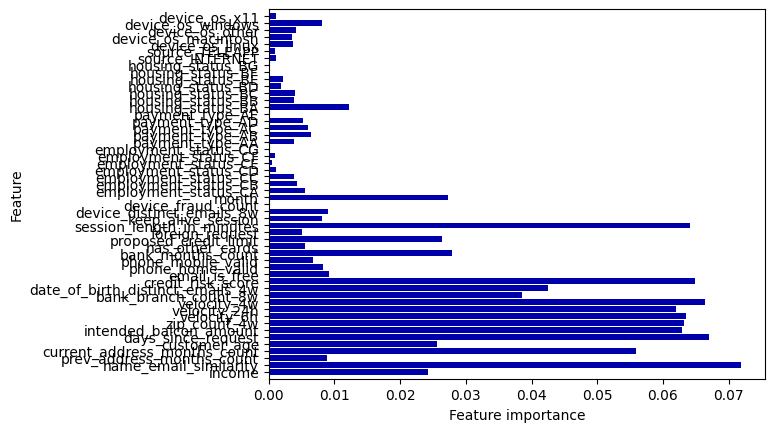

In [58]:
def plot_feature_importances_cancer(model):
    n_features = len(feature_cols)
    plt.barh(np.arange(n_features), model.feature_importances_, align='center')
    plt.yticks(np.arange(n_features), feature_cols)
    plt.xlabel("Feature importance")
    plt.ylabel("Feature")
    plt.ylim(-1, n_features)

plot_feature_importances_cancer(model)